# PySDDR: An Advanced Tutorial

In the beginner's guide only tabular data was used as input to the PySDDR framework. In this advanced tutorial we show the mixed effects of structured and unstructured data. Currently, the framework only supports images as unstructured data.

We will use the MNIST dataset as a source for the unstructured data and generate additional tabular features corresponding to those.

The aim of training is for the model to be able to output a latent effect, representing the number depicted in the MNIST image.

We start by importing the sddr module and other required libraries

In [1]:
# import the sddr module
from sddr import Sddr

import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


#set seeds for reproducibility
torch.manual_seed(1)
np.random.seed(1)

### User inputs 

First the user defines the data to be used. The data is loaded and if it does not already exist a column needs to be added to the tabular data describing the unstructured data - structured data correspondence. In the example below we add a column where each item includes the name of the image to which the current row of tabular data corresponds.

In [5]:
data_path = '../data/mnist_data/tab.csv'

data = pd.read_csv(data_path,delimiter=',')

# append a column for the numbers: each data point contains a file name of the corresponding image
for i in data.index:
    data.loc[i,'numbers'] = f'img_{i}.jpg'

Next the distribution, formulas and training parameters are defined. The size of each image is ```28x28``` so our neural network has a layer which flattens the input, which is followed by a linear layer of input size ```28x28``` and an output size of ```128```. Finally, this is followed by a ```ReLU``` for the activation.

Here the structured data is not pre-loaded as it would be typically too large to load in one step. Therefore the path to the directory in which it is stored is provided along with the data type (for now only 'images' supported). The images are then loaded in batches using PyTorch's dataloader. Note that here again the key given in the ```unstructured_data``` dictionary must match the name it is given in the formula, in this case ```'numbers'```. Similarly the keys of the ```deep_models_dict``` must also match the names in the formula, in this case ```'dnn'```

In [2]:
# define distribution and the formula for the distibutional parameter
distribution  = 'Normal'

formulas = {'loc': '~ -1 + spline(x1, bs="bs", df=10) + x2 + dnn(numbers) + spline(x3, bs="bs", df=10)',
            'scale': '~1'
            }


# define the deep neural networks' architectures and output shapes used in the above formula
deep_models_dict = {
'dnn': {
    'model': nn.Sequential(nn.Flatten(1, -1),
                           nn.Linear(28*28,128),
                           nn.ReLU()),
    'output_shape': 128},
}

# define your training hyperparameters
train_parameters = {
    'batch_size': 8000,
    'epochs': 1000,
    'degrees_of_freedom': {'loc':9.6, 'scale':9.6},
    'optimizer' : optim.Adam
}


# provide the location and datatype of the unstructured data
unstructured_data = {
  'numbers' : {
    'path' : '../data/mnist_data/mnist_images',
    'datatype' : 'image'
  }
}

# define output directory
output_dir = './outputs'


### Initialization

The sddr instance is initialized with the parameters given by the user in the previous step:

In [3]:
sddr = Sddr(output_dir=output_dir,
            distribution=distribution,
            formulas=formulas,
            deep_models_dict=deep_models_dict,
            train_parameters=train_parameters,
            )

Using device:  cpu


### Training

The sddr network is trained with the data defined above and the loss curve is plotted.

Beginning training ...
Train Epoch: 0 	 Loss: 131.097122
Train Epoch: 100 	 Loss: 101.242378
Train Epoch: 200 	 Loss: 76.286522
Train Epoch: 300 	 Loss: 57.460751
Train Epoch: 400 	 Loss: 44.054817
Train Epoch: 500 	 Loss: 34.513153
Train Epoch: 600 	 Loss: 27.706999
Train Epoch: 700 	 Loss: 22.680731
Train Epoch: 800 	 Loss: 18.903719
Train Epoch: 900 	 Loss: 16.009527


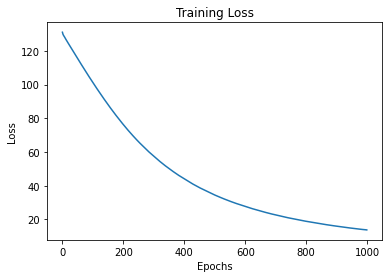

In [6]:
sddr.train(structured_data=data,
           target="y_gen",
           unstructured_data = unstructured_data,
           plot=True)

### Evaluation - Visualizing the partial effects

In this case the data is assumed to follow a normal distribution, in which case two distributional parameters, loc and scale, need to be estimated. Below we plot the partial effects of each

Remember the partial effects are computed by: partial effect = smooth_features * coefs (weights)
In other words the smoothing terms are multiplied with the weights of the Structured Head. We use the partial effects to interpret whether our model has learned correctly.

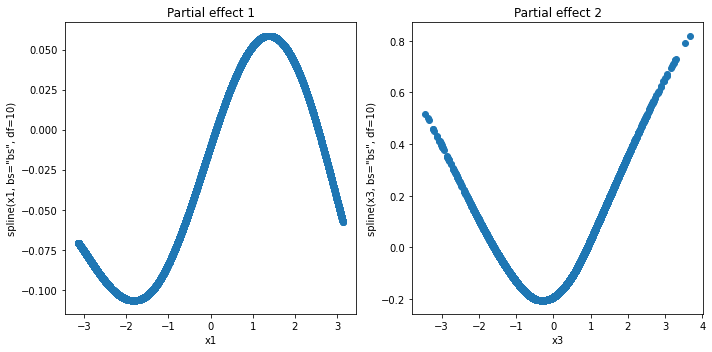

In [7]:
partial_effects_loc = sddr.eval('loc',plot=True)

In [8]:
partial_effects_scale = sddr.eval('scale',plot=True)

Not possible to print any partial effects


<Figure size 720x360 with 0 Axes>

As we can see the distributional parameter loc has two parial effects, one sinusoidal and one quadratic. The parameter scale expectedly has no partial effect since the formula only includes an intercept.

Next we retrieve our ground truth data and compare it with the model's estimation

Predicted variance for first sample: tensor([1.3958])


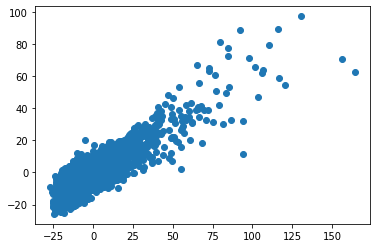

In [10]:
# compare prediction of neural network with ground truth
data_pred = data.loc[:,:]
ground_truth  = data.loc[:,'y_gen']

# predict returns partial effects and a distributional layer that gives statistical information about the prediction
distribution_layer, partial_effect = sddr.predict(data_pred,
                                                  clipping=True, 
                                                  plot=False, 
                                                  unstructured_data = unstructured_data)
# retrieve the mean and  variance of the distributional layer
predicted_mean = distribution_layer.loc[:,:].T
predicted_variance = distribution_layer.scale[0]

# and plot the result
plt.scatter(ground_truth, predicted_mean)
print(f"Predicted variance for first sample: {predicted_variance}")

The comparison shows that for most samples the predicted and true values are directly propotional.

Next we want to check if the model learned the correct correspondence of images and numbers

<AxesSubplot:xlabel='y_true', ylabel='predicted_number'>

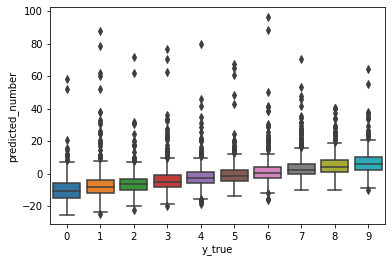

In [11]:
# we create a copy of our original structured data where we set all inputs but the images to be zero
data_pred_copy = data.copy()
data_pred_copy.loc[:,'x1'] = 0
data_pred_copy.loc[:,'x2'] = 0
data_pred_copy.loc[:,'x3'] = 0

# and make a prediction using only the images
distribution_layer, partial_effect = sddr.predict(data_pred_copy,
                                                  clipping=True, 
                                                  plot=False, 
                                                  unstructured_data = unstructured_data)
# add the predicted mean value to our tabular data
data_pred_copy['predicted_number'] = distribution_layer.loc[:,:].numpy().flatten()

# and compare the true number on the images with the predicted number
sns.boxplot(x="y_true", y="predicted_number", data=data_pred_copy)


Observing the boxplot figure we see that as the true values, i.e. numbers depicted on images, are increasing, so too are the medians of the predicted distributions. Therefore the partial effect of the neural network is directly correlated with the number depicted in the MNIST images, proving that our neural network, though simple, has learned from the unstructured data.